In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


# Read datasets

In [2]:
train = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
test = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')

# Split datasets (X,y)

In [3]:
# Separate labels (y) and features (X) for the training DataFrame
X_train = train.iloc[:, 1:]  # Exclude the first column
y_train = train['label']

# Separate labels (y) and features (X) for the testing DataFrame
X_test = test.iloc[:, 1:]  # Exclude the first column
y_test = test['label']

# Check the labels and their distribution:

In [4]:
print(y_train.unique())
print(y_test.unique())

[2 9 6 0 3 4 5 8 7 1]
[0 1 2 3 8 6 5 4 7 9]


We have same number of classes in test and training sets

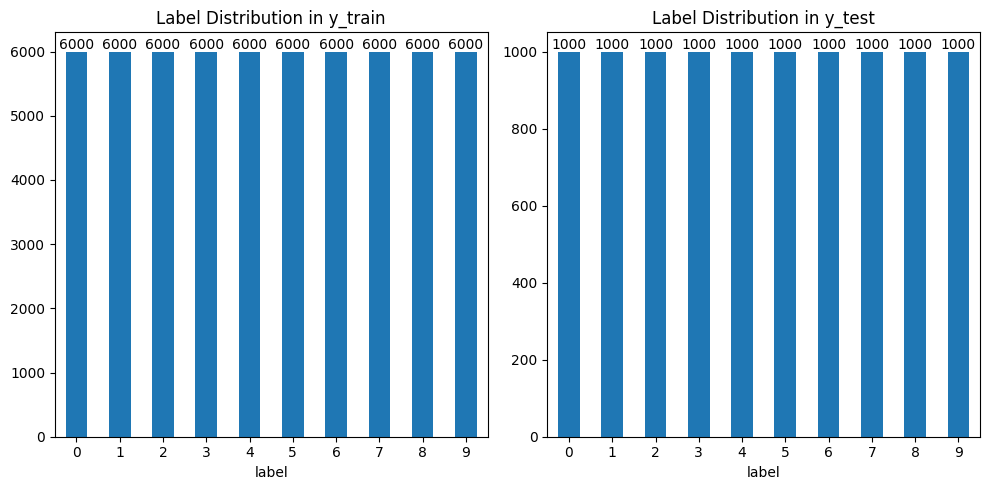

In [5]:
import matplotlib.pyplot as plt

# Combine y_train and y_test to get all labels
all_labels = pd.concat([y_train, y_test], axis=0)

# Get the value counts and sort by index (label)
label_counts = all_labels.value_counts().sort_index()

# Create a bar plot for y_train
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
label_counts_train = y_train.value_counts().sort_index()
label_counts_train.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Label Distribution in y_train')

# Annotate the bars with their counts
for i, count in enumerate(label_counts_train):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Create a bar plot for y_test
plt.subplot(1, 2, 2)
label_counts_test = y_test.value_counts().sort_index()
label_counts_test.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Label Distribution in y_test')

# Annotate the bars with their counts
for i, count in enumerate(label_counts_test):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

We can see we have exactly same distribution

# Check for NAN:

In [6]:
# Check for null values in X_train and X_test
nulls_train = X_train.isnull().sum(axis=1)
nulls_test = X_test.isnull().sum(axis=1)

# Count the number of rows with nulls
rows_with_nulls_train = len(nulls_train[nulls_train > 0])
rows_with_nulls_test = len(nulls_test[nulls_test > 0])

print("Number of rows with nulls in X_train:", rows_with_nulls_train)
print("Number of rows with nulls in X_test:", rows_with_nulls_test)

Number of rows with nulls in X_train: 0
Number of rows with nulls in X_test: 0


We can see we have no nulls and thats good.

# Normalize:

we know each pixel is in values from 0 to 255:  
we will make each pixel value from 0 to 1 and this will help the models to train faster.

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape

In [8]:
# Reshape image in 3 dimensions (Number of rows = -1, height = 28px, width = 28px, channel = 1)
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

-1 means that we dont define number of rows and let python decide which is in our case 60000 row

# Label Encoding :

In [9]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Split val/train :

In [10]:
from sklearn.model_selection import train_test_split

# Split the train and the validation set for the fitting
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

In [11]:
print(f'X_train: {X_train.shape} \ny_train: {y_train.shape}')
print(f'X_val: {X_val.shape} \ny_val: {y_val.shape}')

X_train: (54000, 28, 28, 1) 
y_train: (54000, 10)
X_val: (6000, 28, 28, 1) 
y_val: (6000, 10)


# The model:

In [12]:
def PlotHistory(history,x):
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    # Plot for 40 epochs loss
    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'][x:], label='Training Loss')
    plt.plot(history.history['val_loss'][x:], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training and Validation Loss After {x} Epochs')
    
    plt.tight_layout()
    plt.show()

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create a simple CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=35, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

Epoch 1/35


2023-10-15 09:02:30.406050: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1688/1688 [==============================] - 17s 4ms/step - loss: 0.6034 - accuracy: 0.7766 - val_loss: 0.3832 - val_accuracy: 0.8585
Epoch 2/35
1688/1688 [==============================] - 8s 5ms/step - loss: 0.4106 - accuracy: 0.8504 - val_loss: 0.3247 - val_accuracy: 0.8808
Epoch 3/35
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3611 - accuracy: 0.8679 - val_loss: 0.3063 - val_accuracy: 0.8897
Epoch 4/35
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3317 - accuracy: 0.8788 - val_loss: 0.2784 - val_accuracy: 0.8958
Epoch 5/35
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3128 - accuracy: 0.8856 - val_loss: 0.2640 - val_accuracy: 0.9038
Epoch 6/35
1688/1688 [==============================] - 8s 5ms/step - loss: 0.2985 - accuracy: 0.8887 - val_loss: 0.2671 - val_accuracy: 0.9007
Epoch 7/35
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2853 - accuracy: 0.8935 - val_loss: 0.2509 - val_accuracy: 0.9088
Ep

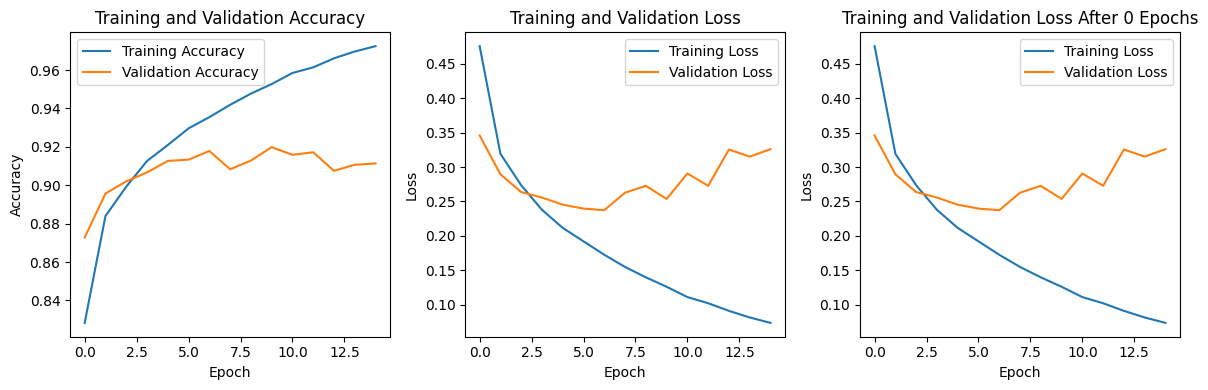

In [89]:
# PlotHistory(history,0) # without dropouts

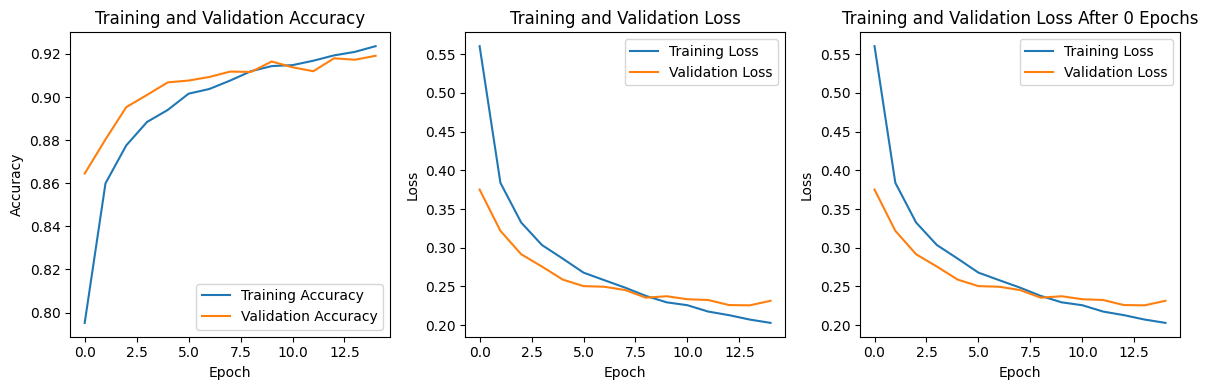

In [91]:
# PlotHistory(history,0) #with dropouts (0.2 0.2 0.1) and 15 epochs

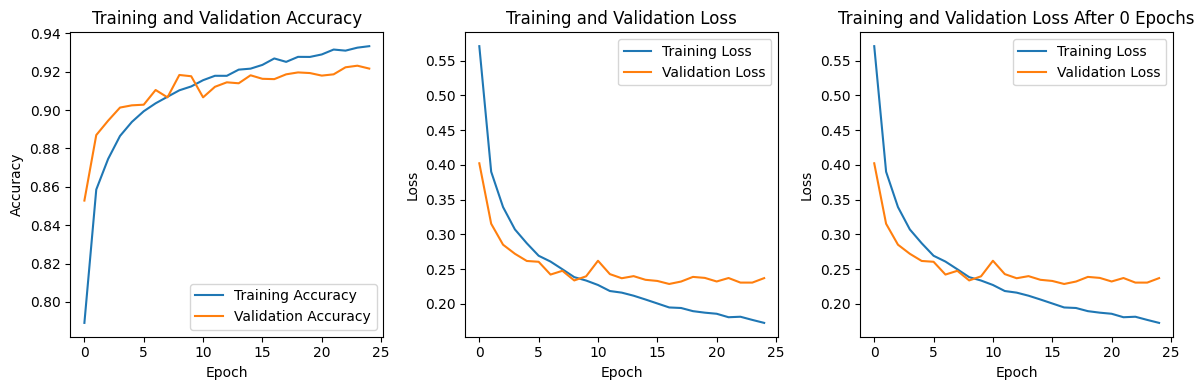

In [94]:
# PlotHistory(history,0) #with dropouts and 25 epochs

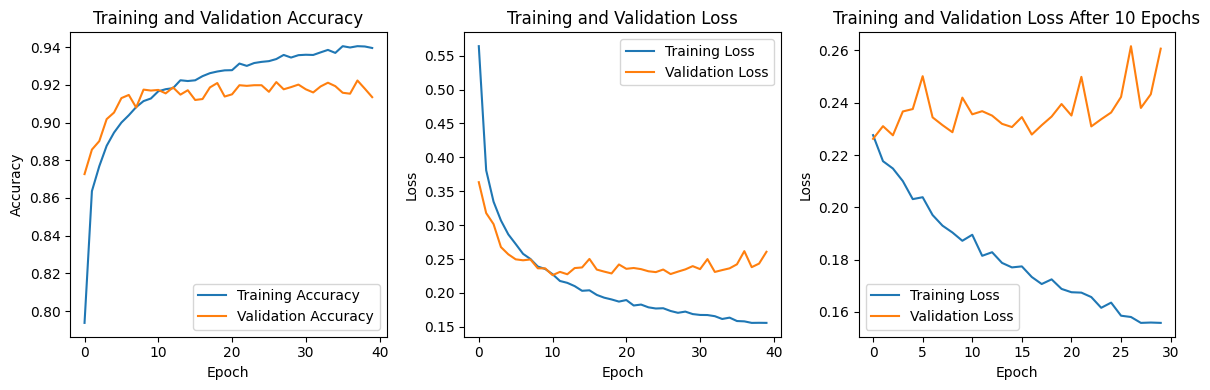

In [97]:
# PlotHistory(history,10) #with dropouts and 40 epochs

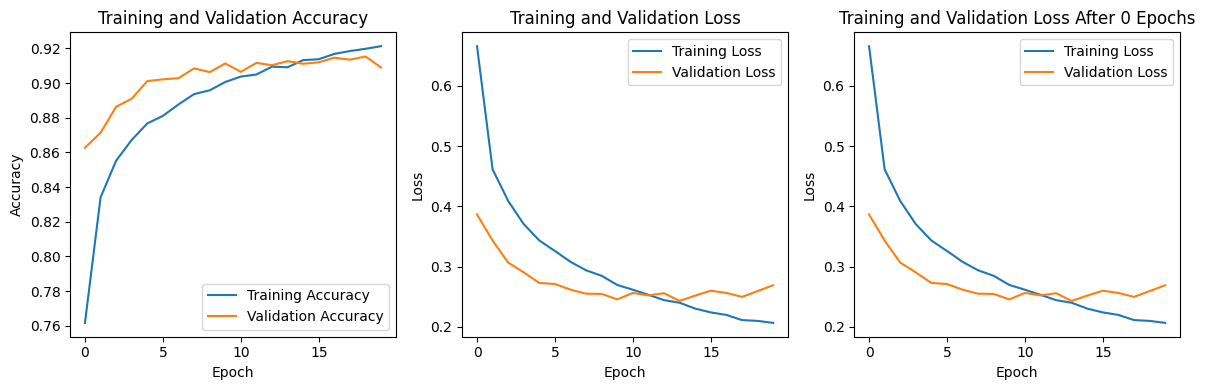

In [100]:
# PlotHistory(history,0) #only 1 dropout

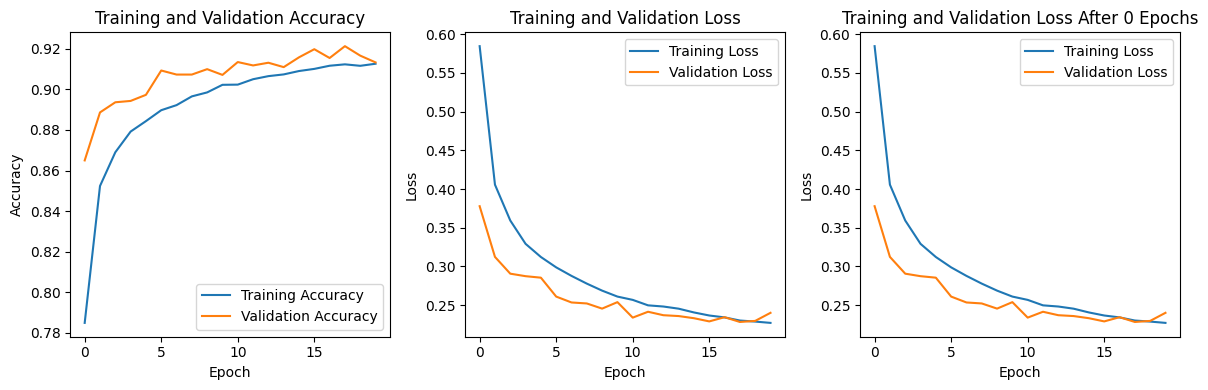

In [102]:
# PlotHistory(history,0) #only 3 dropouts but (0.3 0.3 0.15) 20 epochs

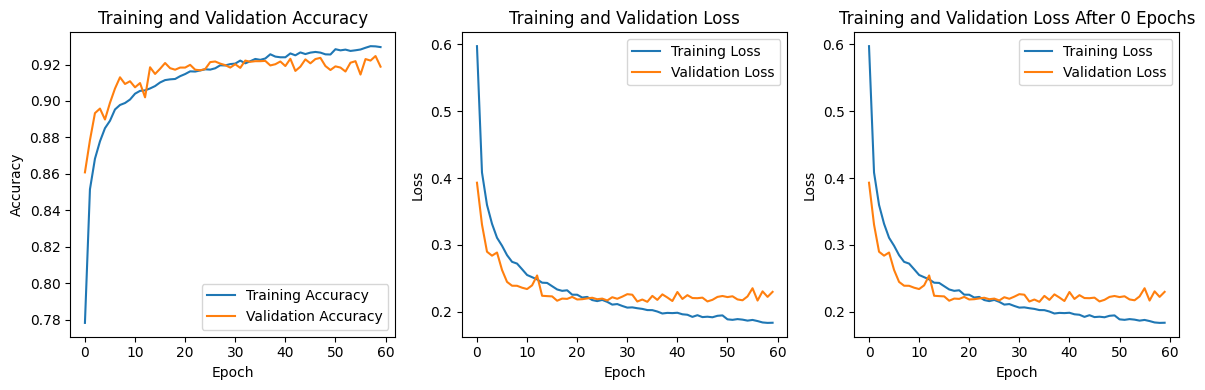

In [108]:
# PlotHistory(history,0) #only 3 dropouts but (0.3 0.3 0.15) 60 epochs

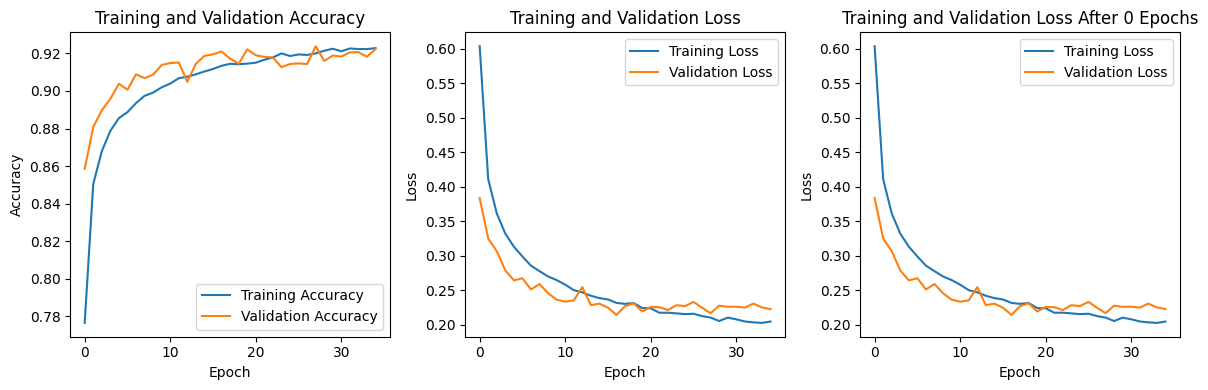

In [14]:
PlotHistory(history,0) #only 3 dropouts but (0.4 0.4 0.3) 35 epochs With Gpu P100 it takes very less time to run

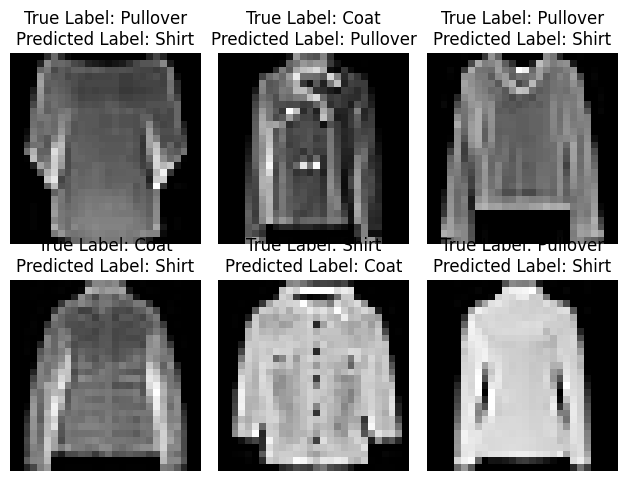

In [16]:
# Create a dictionary to map numerical labels to text labels
label_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Display a few misclassified images with text labels
for i in range(num_images_to_display):
    index = misclassified_indices[i]
    
    # Display the misclassified image
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap='gray')
    
    true_label = label_mapping[np.argmax(y_test[index])]
    predicted_label = label_mapping[np.argmax(predictions[index])]
    
    plt.title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


313/313 [==============================] - 1s 2ms/step


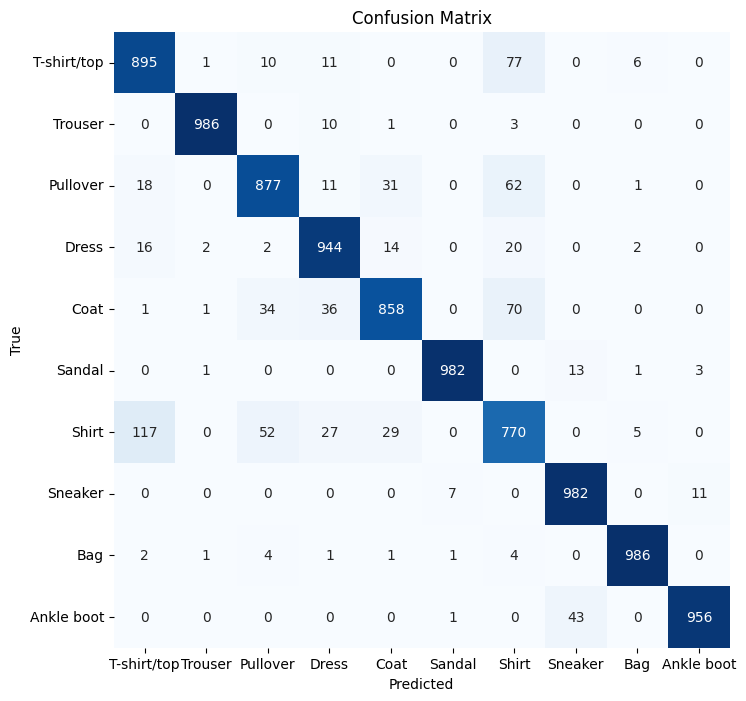

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the model's predictions for the test data
y_pred = model.predict(X_test)

# Convert the one-hot encoded predictions to numerical labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert the one-hot encoded true labels to numerical labels
y_true_labels = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
confusion = confusion_matrix(y_true_labels, y_pred_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()
